In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
import numpy as np
import glob
import os,sys
import copy
# Import Python Libraries
import iris
import iris.plot as iplt
from iris.analysis import MEAN, MAX, SUM
import matplotlib
matplotlib.pyplot.switch_backend('agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%matplotlib inline
acpc_workspace='/group_workspaces/jasmin2/acpc'
acpc_workspace='/gws/nopw/j04/acpc'
#sys.path.append(os.path.join(acpc_workspace,'houston_deep_convection/Intercomparison/acpc_intercomparison'))
sys.path.append('/home/users/pmarinescu/acpc_intercomparison')
sys.path.append('/home/users/pmarinescu')
from acpc_intercomparison_3 import load_variable_cube,color,variable_names,directory,filename
#from Setup_intercomparison import load_variable_cube,color,variable_names,directory,filename
from collections import defaultdict, OrderedDict
f = lambda: defaultdict(f) 

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore')

In [8]:
#plotdir=os.path.join(acpc_workspace,'public/acpc/pmarin','Plots_Apr2020')
#os.makedirs(plotdir,exist_ok=True)

savedir=os.path.join(acpc_workspace,'houston_deep_convection/Processing','Save_2024')
os.makedirs(savedir,exist_ok=True)


In [9]:
models=[]
models.append('COSMO_KIT')
models.append('ICON')
models.append('MesoNH_Toulouse')
models.append('RAMS_CSU')
models.append('UM_LEEDS')
models.append('WRF_NASA')
models.append('WRF_OXF')
models.append('WRF_PNNL')

cases=[]
cases.append('POL')
cases.append('CLN')

modelnames=[]
modelnames.append('COSMO')
modelnames.append('ICON')
modelnames.append('MesoNH')
modelnames.append('RAMS')
modelnames.append('UM')
modelnames.append('NU-WRF')
modelnames.append('WRF-Morr')
modelnames.append('WRF-SBM')

casenames=[]
casenames.append('High-Aero')
casenames.append('Low-Aero')


In [10]:
# Load in ICON data from other location


def call_ICON_mean_profile(vname, case, thr):

    import pickle
    savepath = '/gws/nopw/j04/acpc/users/pmarin/ICON_Profs_2/'
#    thr = 1e-05
#    vname = 'qr'
    print('ICON'+case)
    msum_prof = np.zeros(95)
    csum_prof = np.zeros(95)
    for t in np.arange(48,193):
        filename = 'BC_ICON_'+case+'_'+vname+'_tc'+str(thr)+str(t)+'_prof.p'
        filename = 'BC_ICON_'+case+'_'+vname+'_q_now'+str(thr)+str(t)+'_prof.p'
        #print(filename)
        [prof,cntprof,AGL_profmid] = pickle.load(open( savepath+filename, "rb" ) )

        #print(t,prof,cntprof)
        cntprof[np.isnan(prof)] = 0
        prof[np.isnan(prof)] = 0

        
        msum_prof = msum_prof + (prof*cntprof)
        csum_prof = csum_prof + cntprof
    
    return(msum_prof/csum_prof,csum_prof,AGL_profmid)


In [11]:
#import numpy.ma as ma
#plt.rcParams.update({'font.size': 14})
#fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(21/2.54,50/2.54))
#fig.subplots_adjust(left=0.1,right=0.65,hspace=0.7,
#                 bottom=0.05,top=0.95,wspace=0.4)
#fig.subplots_adjust(left=0.1,right=0.97,wspace=0.2,
#                 bottom=0.05,top=0.80,hspace=0.1)



/gws/nopw/j04/acpc/houston_deep_convection/Processing/Save_2024/QTI
ICONPOL
ICONCLN
_qvarp1
/gws/nopw/j04/acpc/houston_deep_convection/Processing/Save_2024/QTI
ICONPOL
ICONCLN
0 57


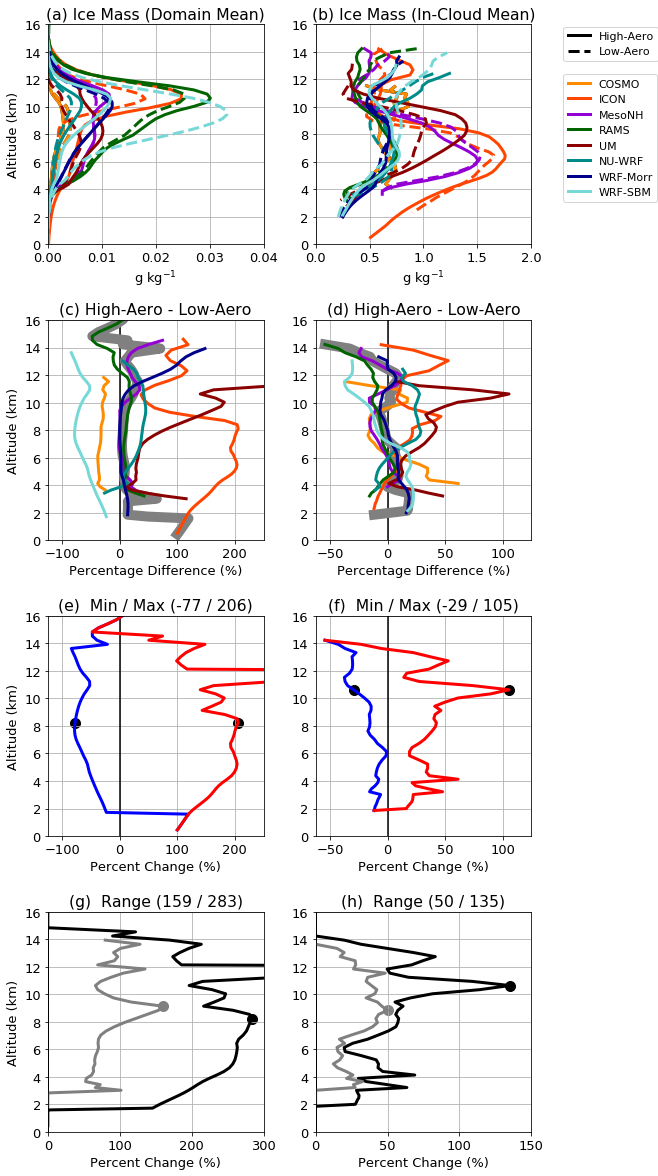

In [14]:
import numpy.ma as ma

plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(24/2.54,42/2.54))
#fig.subplots_adjust(left=0.1,right=0.65,hspace=0.7,
#                 bottom=0.05,top=0.95,wspace=0.4)
#fig.subplots_adjust(left=0.1,right=0.97,wspace=0.2,
#                 bottom=0.05,top=0.80,hspace=0.1)
fig.subplots_adjust(top=0.80,hspace=0.4)


threshs = ['','_qtcp1']
threshs = ['','_qvarp1']
thrs = [0,0.0001]

#threshs = ['_qtcp1']
#thrs = [0.0001]
dx = '500m'; dt = '5m'
# Line Styles for Clean and Polluted Cases
ls={}; ls['CLN']='--'; ls['POL']='-'

varnames = ['QTI']
varnamesi = ['ti']
ttl_l0 = ['(a) ','(b) ']
ttl_l = ['Ice Mass (Domain Mean)','Ice Mass (In-Cloud Mean)']
ttl_r0 = ['(c) ','(d) ']
ttl_2 = ['(e) ','(f) ']
ttl_3 = ['(g) ','(h) ']

ylims = [0,16]
xlims_l = [[0,0.04],[0,2.0]]
xlims_r = [[-125,250],[-62.5,125]]
xlims_ra = [[0,300],[0,150]]
xlbls = ['g kg$^{-1}$','g kg$^{-1}$']
logs = [0,0]
scale_factors = [1000,1000] 

lws = 3
lwl = 3
samp_thr = 10000
temp_arr = ma.masked_array(np.zeros((2,91,len(models))))
min_arr = ma.masked_array(np.zeros((2,91)))
max_arr = ma.masked_array(np.zeros((2,91)))
ran_arr = ma.masked_array(np.zeros((2,91)))
min2_arr = ma.masked_array(np.zeros((2,91)))
max2_arr = ma.masked_array(np.zeros((2,91)))
ran2_arr = ma.masked_array(np.zeros((2,91)))

##################################################
# Load and plot data for XYT Mean
# Loop through thresholds
##################################################

for v in np.arange(0,len(varnames)):
    for i in np.arange(0,len(threshs)):
        print(threshs[i])
        thresh=threshs[i]
        thr=thrs[i]
   
        varname = varnames[v]
        vnamei = varnamesi[v]
        scale_factor = scale_factors[i]
        savedir_i=os.path.join(savedir,varname)
        print(savedir_i)
        var_xyt_mean={}
        var_xyt_numb={}
        model_hgts={}
        for model in models:
            if model == 'ICON':
                for case in cases:
                    [var_xyt_mean[model,case],var_xyt_numb[model,case],model_hgts[model,case]]=call_ICON_mean_profile(vnamei, case, thr)
                    #print(var_xyt_numb[model,case])
            else:
                for case in cases:
                    #print(model,case)
                    var_xyt_mean[model,case]=iris.load_cube(os.path.join(savedir_i,f'{varname}_xyt_mean_{model}_{case}_{dx}_{dt}{thresh}.nc'))
                    var_xyt_numb[model,case]=iris.load_cube(os.path.join(savedir_i,f'{varname}_xyt_numb_{model}_{case}_{dx}_{dt}{thresh}.nc'))
                    model_hgts[model,case] = var_xyt_mean[model,case].coord('geopotential_height').points
                    var_xyt_mean[model,case]=var_xyt_mean[model,case].data
                    var_xyt_numb[model,case]=var_xyt_numb[model,case].data


        # Loop and Plot
        cnt = 0
        for model in models:
            cntc = 0
            for case in cases:
                #print(model,case)
                var_xyt_mean[model,case][var_xyt_numb[model,case] < samp_thr] = np.nan
                if cnt == 0:
                    ax[0,i].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color='k',
                            ls=ls[case],
                            lw=lws,
                            label=f'{casenames[cntc]}')

                    ax[0,i].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls=ls[case],
                            lw=lws,
                            label='_no_legend_')                    
                else:
                    ax[0,i].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls=ls[case],
                            lw=lws)
                cntc = cntc + 1
            cnt = cnt + 1

        ax[0,i].set_xlabel(xlbls[i])
        ax[0,i].set_ylim(ylims)
        ax[0,i].set_xlim(xlims_l[i])
        if logs[i] == 1:
            ax[0,i].set_xscale('log')
        ax[0,i].set_title(ttl_l0[i]+ttl_l[i])

        ##################################################
        # Load and plot data for XYT Mean, no threshold, Absolute Differences and Percentage Differences
        ##################################################
        ax[1,i].plot([0,0],[0,20],'-k',lw=1.5)

        cnt = 0
        for model in models:
            var_pol = var_xyt_mean[model,'POL']*scale_factor
            var_cle = var_xyt_mean[model,'CLN']*scale_factor
            var_pol_n = var_xyt_numb[model,'POL']
            var_cle_n = var_xyt_numb[model,'CLN']           
            var_plot = (var_pol-var_cle) / var_cle * 100    
            var_plot[var_pol < 0.0001] = np.nan
            var_plot[var_cle < 0.0001] = np.nan
            var_plot[var_pol_n < samp_thr] = np.nan
            var_plot[var_cle_n < samp_thr] = np.nan

            # Calculate median and range at each altitude
            if model == 'UM_LEEDS' or model == 'COSMO_KIT' or model == 'ICON':
                var_plot = np.flip(var_plot,axis=0)
            temp_arr[i,:,cnt] = copy.deepcopy(var_plot[0:91])
                   
            cnt = cnt + 1

        min_arr[i,:] = np.nanmin(temp_arr[i,:,:],axis=1)
        max_arr[i,:] = np.nanmax(temp_arr[i,:,:],axis=1)
        ran_arr[i,:] = max_arr[i,:] - min_arr[i,:]

                
        ax[1,i].plot(np.nanmedian(temp_arr[i,:,:],axis=1),model_hgts[model,case][0:91]/1000.0,
                    color='gray',
                    ms=0,
                    linewidth=10,
                    linestyle='-',
                    label='_no_legend_')
            
        cnt = 0
        for model in models:
            var_pol = var_xyt_mean[model,'POL']*scale_factor
            var_cle = var_xyt_mean[model,'CLN']*scale_factor
            var_pol_n = var_xyt_numb[model,'POL']
            var_cle_n = var_xyt_numb[model,'CLN']           
            var_plot = (var_pol-var_cle) / var_cle * 100    
            var_plot[var_pol < 0.0001] = np.nan
            var_plot[var_cle < 0.0001] = np.nan
            var_plot[var_pol_n < samp_thr] = np.nan
            var_plot[var_cle_n < samp_thr] = np.nan

            ax[1,i].plot(var_plot,
                            model_hgts[model,case]/1000.0,
                            color=color[model],
                            ls='-',
                            lw=lwl,
                            label=f'{modelnames[cnt]}')
            cnt = cnt + 1
            
            
        #ax.set_xticks(np.arange(-0.006,0.0021,0.002))
        ax[1,i].set_xlabel('Percentage Difference (%)')
    #    ax[0,1].set_ylabel('Altitude (km)')
        ax[1,i].set_ylim(ylims)
        ax[1,i].set_xlim(xlims_r[i])
        ax[1,i].set_title(ttl_r0[i]+'High-Aero - Low-Aero')

        # Calculate range excluding the min and max values
        for zzz in np.arange(0,91):
            temp_arr[i,zzz,:][temp_arr[i,zzz,:] == min_arr[i,zzz]] = np.nan
            temp_arr[i,zzz,:][temp_arr[i,zzz,:] == max_arr[i,zzz]] = np.nan
        min2_arr[i,:] = np.nanmin(temp_arr[i,:,:],axis=1)
        max2_arr[i,:] = np.nanmax(temp_arr[i,:,:],axis=1)
        ran2_arr[i,:] = max2_arr[i,:] - min2_arr[i,:]
        

# Define altitude range for finding model ensemble statistics
id0 = 0 #km
id1 = 11 #km
zid0 = int(np.where(np.abs(model_hgts[model,case][0:91]/1000.0-id0) == np.min(np.abs(model_hgts[model,case][0:91]/1000.0-id0)))[0])
zid1 = int(np.where(np.abs(model_hgts[model,case][0:91]/1000.0-id1) == np.min(np.abs(model_hgts[model,case][0:91]/1000.0-id1)))[0])
print(zid0,zid1) # Print Model Levels
    
# Add Min Max Range to all plots    
for i in np.arange(0,2):
    
    mid = int(np.where(ran_arr[i,zid0:zid1] == np.nanmax(ran_arr[i,zid0:zid1]))[0])
    mid2 = int(np.where(ran2_arr[i,zid0:zid1] == np.nanmax(ran2_arr[i,zid0:zid1]))[0])

    
    if i == 1:
        xlims = [-50,150]
        xlims2 = [0,150]
    else:
        xlims = [-150,300]
        xlims2 = [0,500]

    lw = 3
    ss = 100
    cs = ['blue','red','black','grey']    
    
    ax[2,i].plot(np.zeros(91),model_hgts[model,case][0:91]/1000.0,lw=1.5,c='k')
    ax[2,i].plot(min_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[0])
    ax[2,i].plot(max_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[1])
    ax[2,i].scatter(min_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
    ax[2,i].scatter(max_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
    ax[2,i].set_title(ttl_2[i]+' Min / Max ('+str(int(min_arr[i,mid]))+' / '+str(int(max_arr[i,mid]))+')',color=cs[2])
    #ax[0].set_title(r'\textcolor{blue}{Min}'+' / Max ('+str(np.round(min_arr[i,mid],1))+' / '+str(np.round(max_arr[i,mid],1))+')',color=cs[2])
    ax[2,i].set_xlabel('Percent Change (%)')
    ax[2,i].set_ylim(ylims)
    ax[2,i].set_xlim(xlims_r[i])

    ax[3,i].plot(np.zeros(91),model_hgts[model,case][0:91]/1000.0,lw=1,c='k')
    ax[3,i].plot(ran_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[2])
    ax[3,i].scatter(ran_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
    ax[3,i].plot(ran2_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[3])
    ax[3,i].scatter(ran2_arr[i,mid2],model_hgts[model,case][mid2]/1000.0,s=ss,c=cs[3])
    ax[3,i].set_title(ttl_3[i]+' Range ('+str(int(ran2_arr[i,mid2]))+' / '+str(int(ran_arr[i,mid]))+')',color=cs[2])
    ax[3,i].set_xlabel('Percent Change (%)')
    ax[3,i].set_ylim(ylims)
    ax[3,i].set_xlim(xlims_ra[i])
        
# Added gridded lines on all the plots
for i in np.arange(0,4):
#    ax[i,1].set_yticklabels([''])
    for j in np.arange(0,2):
        ax[i,0].set_ylabel('Altitude (km)')
        ax[i,j].grid()
    
#plt.tight_layout()   
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, fontsize=12, loc='lower right',bbox_to_anchor=[0.95,0.06])
#fig.legend(handles, labels, fontsize=12, loc='upper left', ncol=1, bbox_to_anchor=[0.015,0.83])

#handles, labels = ax[1,0].get_legend_handles_labels()
#fig.legend(handles, labels, fontsize=12, loc='lower right',bbox_to_anchor=[0.95,0.43])
#fig.legend(handles, labels, fontsize=12, loc='upper left', ncol=4, bbox_to_anchor=[0.22,0.83])

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=11, loc='upper left', ncol=1, bbox_to_anchor=[0.82,0.97])

handles, labels = ax[1,0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=11, loc='upper left', ncol=1, bbox_to_anchor=[0.82,0.93])


plotdir = '/gws/nopw/j04/acpc/public/pmarin/BAMS/Figs_2024/'
savename = 'PubBC_ACPC_I_dom+cld0.1_Profiles'+'_samp'+str(int(samp_thr))+'_minmaxran'
fig.tight_layout(rect=[0,0,0.83,1.0])
fig.savefig(os.path.join(plotdir,savename+'.pdf'),dpi=300) 
fig.savefig(os.path.join(plotdir,savename+'.png'),dpi=300) 
fig.savefig(os.path.join(plotdir,savename+'.eps'),dpi=300)

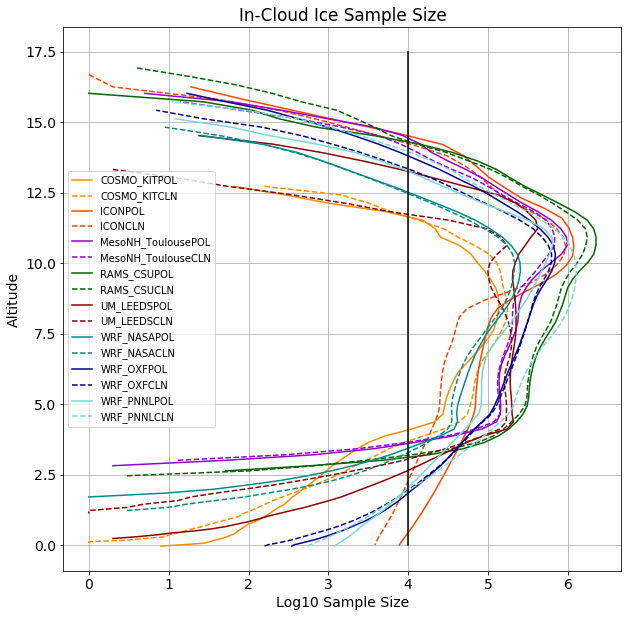

In [28]:
plt.figure(figsize=[10,10])
cases = ['POL','CLN']
for model in models:
    for case in cases:
        plt.plot(np.log10(var_xyt_numb[model,case]),model_hgts[model,case]/1000,
                            color=color[model],ls=ls[case],label=model+case)

plt.plot([np.log10(10000),np.log10(10000)],[0,17.5],'-k')
        
plt.legend(fontsize=10)
plt.xlabel('Log10 Sample Size')
plt.ylabel('Altitude')
plt.title('In-Cloud Ice Sample Size')
plt.grid()